## CNN Regression on Galsim simulation data
Ziwei Qiu: ziweiqiu@g.harvard.edu

### Import libraries

In [1]:
import sys
import math
import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

###  Import data, make train and test datasets

**The 'label' in the data set is a concatenate of physical parameters (flux, sersic index, sersic radius, g1, g2). g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. g1= (1-q)/(1+q) cos phi and g2= (1-q)/(1+q) sin phi, where q is ellipticity and phi is orientation. ***

Here is literature: http://2017.ds3-datascience-polytechnique.fr/wp-content/uploads/2017/08/DS3_posterID_012.pdf

In [2]:
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('Data1.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)
split = int(0.8*total_num)

total number of images: 18779


In [3]:
np.random.seed(100)
ind = np.arange(total_num)
np.random.shuffle(ind)
train_ind = ind[0:split]
train_ind = list(np.sort(train_ind))
test_ind = ind[split:]
test_ind = list(np.sort(test_ind))
print('random indices created.')

# train dataset
image_tr = f['img'][train_ind]
cat_tr = f['cat'][train_ind]  
label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
snr_tr = f['snr'][train_ind]
sigma_tr = f['sigma'][train_ind]
image_nonoise_tr = f['img_nonoise'][train_ind]    
image_withnoise_tr = f['img_withnoise'][train_ind]
print('training set done.')

# test dataset
image_te = f['img'][test_ind]
cat_te = f['cat'][test_ind]  
label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
snr_te = f['snr'][test_ind]
sigma_te = f['sigma'][test_ind]
image_nonoise_te = f['img_nonoise'][test_ind]    
image_withnoise_te = f['img_withnoise'][test_ind]   
print('test set done.')

# Reshape such that the images are ready for training
image_tr = image_tr.reshape(image_tr.shape[0],64,64,1)
image_te = image_te.reshape(image_te.shape[0],64,64,1)

random indices created.
training set done.
test set done.


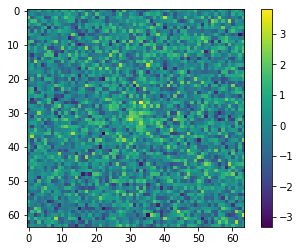

In [4]:
# An example from the training set
plt.imshow(image_tr[1,:,:,0])
plt.colorbar()
plt.show()

In [5]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

###  Define the common functions for regression on different parameters

#### Define a function so the training process will automatically save the weights with the lowest possible validation loss, and stopped the training within a pre-defined time

In [6]:
# save the lowest val_loss model and top when the time is over
def smart_training(cnnmodel, label_ind, weight_filename, 
                   max_time_min = 45, lr_ini = 0.001, lr_decay = 0.8, 
                   val_loss_goal = 0.05, verbose=0):
    
    ''' max_time_min: the longest training time in minutes '''
    
    tic = time.time()
    lr = lr_ini
    opt = SGD(lr=lr, momentum=0.9)
    cnnmodel.compile(optimizer=opt,loss='mae',  metrics=['mse','mae'])
    cnnmodel_fit = cnnmodel.fit(image_tr, label_tr_scaled[:,label_ind], epochs=1,
                                batch_size=20, shuffle=True, verbose=verbose, 
                                validation_data=(image_te, label_te_scaled[:,label_ind]))
    cnnmodel.save_weights(weight_filename)
    current_val_loss = cnnmodel_fit.history['val_loss'][-1]
    print('==> Current val_loss lowest record is: {:0.6f}. Weights saved.'.format(current_val_loss))
    
    while True:
        if time.time() - tic > max_time_min*60:
            print('{} min has passed. Time is over!'.format(max_time_min))
            break
        
        cnnmodel_fit = cnnmodel.fit(image_tr, label_tr_scaled[:,label_ind], epochs=1,
                                    batch_size=20, shuffle=True, verbose=verbose, 
                                    validation_data=(image_te, label_te_scaled[:,label_ind]))
        if cnnmodel_fit.history['val_loss'][-1] < current_val_loss:
            cnnmodel.save_weights(weight_filename)
            current_val_loss = cnnmodel_fit.history['val_loss'][-1]
            print('==> Current val_loss lowest record is: {:0.6f}. Weights saved.'.format(current_val_loss))
            lr = lr*lr_decay
            opt = SGD(lr=lr, momentum=0.9)
            cnnmodel.compile(optimizer=opt,loss='mae',  metrics=['mse','mae'])
        if current_val_loss < val_loss_goal:
            print('Reached the goal! (total training time: {} min)'.format(int((time.time() - tic)/60)))
            break

#### Load pre-trained weights and evaluate the validation loss

In [7]:
def load_weights(cnnmodel, label_ind, weight_filename):
    #opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt = SGD(lr=0.001, momentum=0.9)
    cnnmodel.compile(optimizer=opt, loss='mae', metrics=['mse','mae'])
    cnnmodel.load_weights(weight_filename)
    print("Loaded " + weight_filename + " from disk")
    
    #  Evaluate the model on the validation data:
    val_loss = cnnmodel.evaluate(image_te, label_te_scaled[:,label_ind],verbose = 0)
    print('The validation loss MAE is {:0.6f}.'.format(val_loss[0]))

#### Visualize the prediction versus true values using test data

In [8]:
# Evaluation
def plot_prediction(cnnmodel, label_ind, num_of_pts = 200):

    indices = np.random.randint(0,image_te.shape[0],num_of_pts)
    #single_scaler = MinMaxScaler()
    single_scaler = StandardScaler()
    single_scaler.fit(np.expand_dims(label_tr[:,label_ind],axis=1))

    label_pred_scaled = cnnmodel.predict(image_te[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    fig= plt.figure(figsize=(5,4))
    plt.scatter(label_te[indices,label_ind],label_pred, 
                c = snr_te[indices], cmap="seismic", s = 20)
    plt.plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')

    plt.xlabel('True Value', fontsize = 13)
    plt.ylabel('Predicted Value', fontsize = 13)
    plt.title(label_names_list[label_ind], fontsize = 13)

    clb = plt.colorbar()
    clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    plt.show()

### Regression on the label0 flux

In [9]:
label_ind = 0

cnnmodel1 = models.Sequential()
#cnnmodel1.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Flatten())
cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(1, activation='linear'))
cnnmodel1.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         136       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         1032      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        2064      
____

In [10]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_lb0_flux_good.h5', max_time_min = 60, verbose = 0)

==> Current val_loss lowest record is: 0.351408. Weights saved.
==> Current val_loss lowest record is: 0.342770. Weights saved.
==> Current val_loss lowest record is: 0.338633. Weights saved.
==> Current val_loss lowest record is: 0.337796. Weights saved.
==> Current val_loss lowest record is: 0.336619. Weights saved.
60 min has passed. Time is over!


In [11]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_lb0_flux_good.h5')

Loaded cnnmodel_lb0_flux_good.h5 from disk
The validation loss MAE is 0.336619.


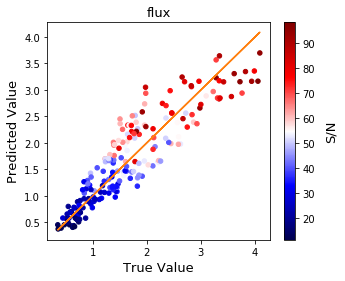

In [12]:
plot_prediction(cnnmodel1, label_ind)

### Regression on the label1 sersic index

In [13]:
label_ind = 1
cnnmodel1 = models.Sequential()
#cnnmodel1.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Flatten())
cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(1, activation='linear'))
#cnnmodel1.summary()

In [13]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_lb1_index_t.h5', max_time_min = 5, verbose = 1)

Train on 15023 samples, validate on 3756 samples
15023/15023 [==============================] - 147s 10ms/sample - loss: 0.5485 - mse: 0.5042 - mae: 0.5485 - val_loss: 0.5387 - val_mse: 0.4975 - val_mae: 0.5387
==> Current val_loss lowest record is: 0.539.
Train on 15023 samples, validate on 3756 samples
15023/15023 [==============================] - 151s 10ms/sample - loss: 0.5457 - mse: 0.5003 - mae: 0.5457 - val_loss: 0.5342 - val_mse: 0.5035 - val_mae: 0.5342
==> Current val_loss lowest record is: 0.534.
Train on 15023 samples, validate on 3756 samples
15023/15023 [==============================] - 138s 9ms/sample - loss: 0.5438 - mse: 0.4958 - mae: 0.5438 - val_loss: 0.5186 - val_mse: 0.4634 - val_mae: 0.5186
==> Current val_loss lowest record is: 0.519.
5 min has passed. Time is over!


In [15]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_lb1_index_good.h5', max_time_min = 20, verbose = 0)

==> Current val_loss lowest record is: 0.531.
==> Current val_loss lowest record is: 0.530.
==> Current val_loss lowest record is: 0.524.
==> Current val_loss lowest record is: 0.520.
==> Current val_loss lowest record is: 0.517.
20 min has passed. Time is over!


In [15]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_lb1_index_good.h5')

Loaded cnnmodel_lb1_index_good.h5 from disk
The validation loss MAE is 0.516987.


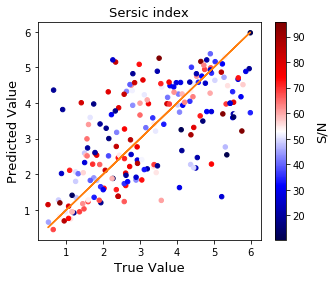

In [16]:
plot_prediction(cnnmodel1, label_ind)

### Regression on the label2 Sersic radius

In [17]:
label_ind = 2

cnnmodel1 = models.Sequential()
#cnnmodel1.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Flatten())
cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(1, activation='linear'))

In [17]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_lb2_radius_good.h5', max_time_min = 60, verbose = 0)

==> Current val_loss lowest record is: 0.744084. Weights saved.
==> Current val_loss lowest record is: 0.678662. Weights saved.
==> Current val_loss lowest record is: 0.636631. Weights saved.
==> Current val_loss lowest record is: 0.613760. Weights saved.
==> Current val_loss lowest record is: 0.607361. Weights saved.
==> Current val_loss lowest record is: 0.594982. Weights saved.
==> Current val_loss lowest record is: 0.588072. Weights saved.
==> Current val_loss lowest record is: 0.585487. Weights saved.
==> Current val_loss lowest record is: 0.584616. Weights saved.
==> Current val_loss lowest record is: 0.578630. Weights saved.
60 min has passed. Time is over!


In [18]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_lb2_radius_good.h5')

Loaded cnnmodel_lb2_radius_good.h5 from disk
The validation loss MAE is 0.578630.


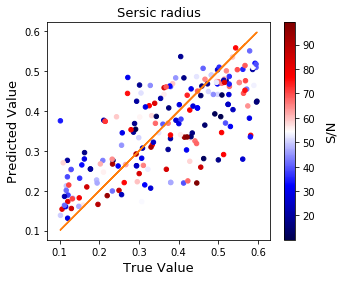

In [19]:
plot_prediction(cnnmodel1, label_ind)

### Regression on the label3 g1

In [20]:
label_ind = 3

cnnmodel1 = models.Sequential()
#cnnmodel1.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Flatten())
cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(1, activation='linear'))

In [21]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_lb3_g1_good.h5', max_time_min = 60, verbose = 0)

==> Current val_loss lowest record is: 0.435888. Weights saved.
==> Current val_loss lowest record is: 0.381371. Weights saved.
==> Current val_loss lowest record is: 0.350907. Weights saved.
==> Current val_loss lowest record is: 0.347099. Weights saved.
==> Current val_loss lowest record is: 0.341176. Weights saved.
==> Current val_loss lowest record is: 0.328823. Weights saved.
==> Current val_loss lowest record is: 0.327628. Weights saved.
==> Current val_loss lowest record is: 0.321944. Weights saved.
==> Current val_loss lowest record is: 0.320992. Weights saved.
==> Current val_loss lowest record is: 0.317611. Weights saved.
60 min has passed. Time is over!


In [21]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_lb3_g1_good.h5')

Loaded cnnmodel_lb3_g1_good.h5 from disk
The validation loss MAE is 0.317611.


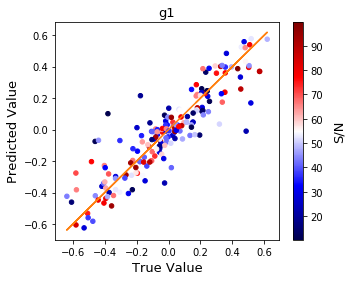

In [22]:
plot_prediction(cnnmodel1, label_ind)

### Regression on the label4 g2

In [23]:
label_ind = 4

cnnmodel1 = models.Sequential()
#cnnmodel1.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))
cnnmodel1.add(Dropout(0.1))

cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel1.add(layers.BatchNormalization())
cnnmodel1.add(layers.MaxPooling2D((2, 2)))

cnnmodel1.add(layers.Flatten())
cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel1.add(layers.Dense(1, activation='linear'))

In [25]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_lb4_g2_good.h5', max_time_min = 60, verbose = 0)

==> Current val_loss lowest record is: 0.562272. Weights saved.
==> Current val_loss lowest record is: 0.386501. Weights saved.
==> Current val_loss lowest record is: 0.364553. Weights saved.
==> Current val_loss lowest record is: 0.362835. Weights saved.
==> Current val_loss lowest record is: 0.348441. Weights saved.
==> Current val_loss lowest record is: 0.333603. Weights saved.
==> Current val_loss lowest record is: 0.329999. Weights saved.
==> Current val_loss lowest record is: 0.329637. Weights saved.
==> Current val_loss lowest record is: 0.327571. Weights saved.
==> Current val_loss lowest record is: 0.326975. Weights saved.
60 min has passed. Time is over!


In [24]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_lb4_g2_good.h5')

Loaded cnnmodel_lb4_g2_good.h5 from disk
The validation loss MAE is 0.326975.


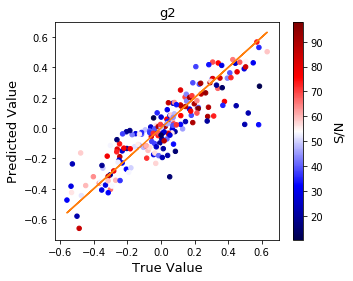

In [25]:
plot_prediction(cnnmodel1, label_ind)